In [3]:
from ortools.linear_solver import pywraplp
import numpy as np

# Wind effect parameters
alpha = 0.5  # Weight for time cost
beta = 0.5   # Weight for energy cost

# Add number of tasks
num_tasks = 6  # The number of tasks can be changed randomly between 1-10.

# Define constants for drone and vehicle properties
drone_speed = 10  # Drone speed in units per time
vehicle_speed = 30  # Vehicle speed in units per time
drone_power = 50  # Drone power consumption per time unit
vehicle_efficiency = 0.2  # Vehicle efficiency (energy per distance unit)

# Randomly generate task distances for drones and vehicles
np.random.seed(42)
distance_drone = np.random.randint(5, 20, size=num_tasks)  # Distances for drone tasks
distance_vehicle = np.random.randint(5, 20, size=num_tasks)  # Distances for vehicle tasks

# Calculate time and energy for each drone and vehicle based on their speeds and powers
time_drone = [d / drone_speed for d in distance_drone]
time_vehicle = [d / vehicle_speed for d in distance_vehicle]

energy_drone = [drone_power * t for t in time_drone]
energy_vehicle = [d * vehicle_efficiency for d in distance_vehicle]

# Create the optimization model
solver = pywraplp.Solver.CreateSolver('SCIP')
if not solver:
    print('Solver not created!')
    exit()

# Create decision variables for each task, indicating if it's assigned to a drone or vehicle
x = {}
y = {}
for i in range(num_tasks):
    x[i] = solver.BoolVar(f'drone_{i}')
    y[i] = solver.BoolVar(f'vehicle_{i}')

# Wind effect parameters (using linear approximation model)
V_w = 10  # Wind speed (constant for simplicity)
wind_direction_cosine = [1.0, 0.707, 0, -0.707, -1.0, -0.707, 0, 0.707]  # Cosine of wind direction (8 directions)
alpha_wind = 0.8  # Wind influence factor

# Add wind effect constraints: linear approximation for drone range under wind influence
R_0 = 100  # Maximum range of drone in no-wind conditions
drone_range_with_wind = []
for i in range(num_tasks):
    # Assume that wind effect influences range (simplified linear model)
    # R_i = R_0 * (1 - alpha * (V_w / V) * cos(theta))
    # For simplicity, use one of the wind directions (adjustable)
    wind_effect = alpha_wind * (V_w / drone_speed) * wind_direction_cosine[i % len(wind_direction_cosine)]
    drone_range_with_wind.append(R_0 * (1 - wind_effect))  # Adjust drone range based on wind

# Objective: Minimize total cost, which is a combination of time and energy
total_time = solver.Sum([x[i] * time_drone[i] for i in range(num_tasks)]) + solver.Sum([y[i] * time_vehicle[i] for i in range(num_tasks)])
total_energy = solver.Sum([x[i] * energy_drone[i] for i in range(num_tasks)]) + solver.Sum([y[i] * energy_vehicle[i] for i in range(num_tasks)])

solver.Minimize(alpha * total_time + beta * total_energy)

# Constraint 1: Each task must be assigned to either a drone or a vehicle
for i in range(num_tasks):
    solver.Add(x[i] + y[i] == 1)

# Constraint 2: The drone cannot exceed its adjusted range (with wind effect)
for i in range(num_tasks):
    solver.Add(x[i] * distance_drone[i] <= drone_range_with_wind[i])

# Optional Constraint 3: Limit each path to have at most one task (optional, depending on scheduling needs)
for i in range(num_tasks):
    solver.Add(x[i] <= 1)
    solver.Add(y[i] <= 1)

# Solve the model
status = solver.Solve()

# Print the status and results
if status == pywraplp.Solver.OPTIMAL:
    print("Status: OPTIMAL")
    print("Total cost: ", solver.Objective().Value())

    # Output the assignment of tasks to drones and vehicles
    for i in range(num_tasks):
        print(f"Task {i} is assigned to drone: {x[i].solution_value()}")
        print(f"Task {i} is assigned to vehicle: {y[i].solution_value()}")
else:
    print("The problem does not have an optimal solution.")


load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\zlib1.dll...
load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\re2.dll...
load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\highs.dll...
load D:\Users\王凯立\AppData\Local\Programs\Python\Python312\Lib\site-packages\ortools\.libs\ortools.dll...
Status: OPTIMAL
Total cost:  8.05
Task 0 is assigned to drone: 0.0
Task 0 is assigned to vehicle: 1.0
Task 1 is assigned to drone: 0.0
Task 1 is assigned to vehicle: 1.0
Task 2 is assigned to drone: 0.0
Task 2 is assigned to vehicle: 1.0
Task 3 is assigned to 

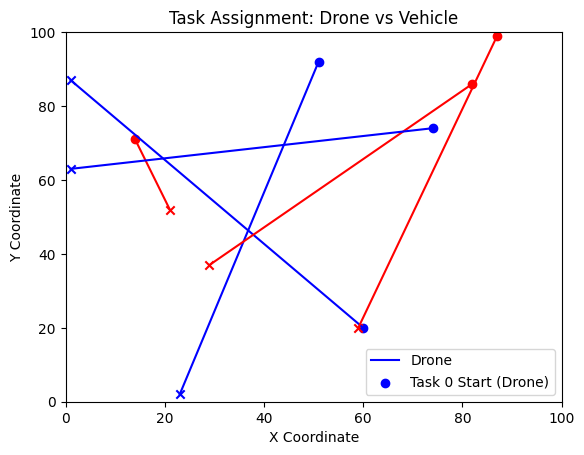

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Assume that the number of tasks generated is 6, the starting and ending points of the tasks
num_tasks = 6
np.random.seed(42)

# Randomly generate the starting and ending coordinates of the task (assuming they are in a 100x100 area)
start_points = np.random.randint(0, 100, (num_tasks, 2))
end_points = np.random.randint(0, 100, (num_tasks, 2))

# UAV and vehicle task allocation (assuming the allocation result is obtained through optimization)
# Here we assume that the task allocation is given manually, 0 means allocation to the UAV, 1 means allocation to the vehicle
task_assignments = [0, 1, 0, 1, 0, 1]  # Assume that tasks 1, 3, and 5 are assigned to drones, and tasks 2, 4, and 6 are assigned to vehicles

# Draw the graphics
fig, ax = plt.subplots()

# Draw the start and end points of the task
for i in range(num_tasks):
    if task_assignments[i] == 0:
        # If the task is assigned to a drone, it is indicated in blue
        ax.plot([start_points[i][0], end_points[i][0]], 
                [start_points[i][1], end_points[i][1]], 'b-', label='Drone' if i == 0 else "")
        ax.scatter(start_points[i][0], start_points[i][1], c='blue', label=f"Task {i} Start (Drone)" if i == 0 else "")
        ax.scatter(end_points[i][0], end_points[i][1], c='blue', marker='x', label=f"Task {i} End (Drone)" if i == 0 else "")
    else:
        # If the task is assigned to a vehicle, it is indicated in red
        ax.plot([start_points[i][0], end_points[i][0]], 
                [start_points[i][1], end_points[i][1]], 'r-', label='Vehicle' if i == 1 else "")
        ax.scatter(start_points[i][0], start_points[i][1], c='red', label=f"Task {i} Start (Vehicle)" if i == 1 else "")
        ax.scatter(end_points[i][0], end_points[i][1], c='red', marker='x', label=f"Task {i} End (Vehicle)" if i == 1 else "")

# Set the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2])

# Add title and labels
ax.set_title('Task Assignment: Drone vs Vehicle')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')

# Set the graphics display range
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])

# Display the graph
plt.show()
